In [16]:
#Imports for reading the csv file
import csv
from csv import writer
from csv import reader
import pandas as pd

Dividing Draft Trades into those involving picks from the current year and those involving both current and future picks.

In [17]:
with open('Final_Draft_Trades.csv', 'r') as f:
      reader = csv.reader(f)
      f.readline()
      listOfCurrentYearTrades=[] 
      listOfDifferentYearTrades=[]
      for row in reader:
        counter=0
        for i in row:
          newLine=i.split(', ')
          for i in newLine:
            if counter==0:
              result = all(element == newLine[0] for element in newLine) #Checks if the trade involves only current picks or current and future picks
              if result:
                listOfCurrentYearTrades.append(row)
              else:
                listOfDifferentYearTrades.append(row)
              counter+=1

print(len(listOfCurrentYearTrades))
print(len(listOfDifferentYearTrades))

191
165


Splitting current year trades into a list of draft picks used to trade up and to trade down.

In [18]:
valueForTradePart1=[] #Lists with the integer values for each draft pick
valueForTradePart2=[]
temp=[]
tradingUp=[] #List to check statistics on trading up and trading down 
tradingDown=[]
tradingUpPicks=[] #List of picks used to trade up
tradingDownPicks=[] #List of picks used to trade down
for i in listOfCurrentYearTrades:
  valueForTradePart1.append(i[1].split(', '))
  valueForTradePart2.append(i[2].split(', '))
for i in range(len(valueForTradePart1)):
  temp=[]
  for j in range(len(valueForTradePart1[i])):
    valueForTradePart1[i][j]=int(valueForTradePart1[i][j])
    temp.append(valueForTradePart1[i][j])
  for k in range(len(valueForTradePart2[i])):
    valueForTradePart2[i][k]=int(valueForTradePart2[i][k])
    temp.append(valueForTradePart2[i][k])
  highestPick=min(temp) #Determines which pick is the highest in the trade to determine which side of the trade is trading up or trading down
  if highestPick in valueForTradePart2[i]:
    tradingUp.append(len(valueForTradePart2[i]))
    tradingDown.append(len(valueForTradePart1[i]))
    tradingDownPicks.append(valueForTradePart2[i])
    tradingUpPicks.append(valueForTradePart1[i])
  else:
    tradingUp.append(len(valueForTradePart1[i]))
    tradingDown.append(len(valueForTradePart2[i]))
    tradingDownPicks.append(valueForTradePart1[i])
    tradingUpPicks.append(valueForTradePart2[i])

Key statistics on trading up and trading down for draft picks.

In [19]:
import numpy as np
import statistics
dictDifferentTypesOfTrades={}
#Classifying the types of current year trades
for i in range(len(tradingUpPicks)):
  if len(tradingUpPicks[i])>len(tradingDownPicks[i]):
    typeOfTrade=(len(tradingUpPicks[i]),len(tradingDownPicks[i]))
  else:
    typeOfTrade=(len(tradingDownPicks[i]),len(tradingUpPicks[i]))
  if typeOfTrade==(1,1):
    print(tradingDownPicks[i],tradingUpPicks[i])
  if typeOfTrade in dictDifferentTypesOfTrades:
    dictDifferentTypesOfTrades[typeOfTrade]+=1
  else:
    dictDifferentTypesOfTrades[typeOfTrade]=1
#Statistics on current year trades
print(statistics.mean(tradingUp))
print(statistics.mean(tradingDown))
print(statistics.median(tradingUp))
print(statistics.median(tradingDown))
print(max(tradingUp))
print(max(tradingDown))
print(statistics.stdev(tradingUp))
print(statistics.stdev(tradingDown))
print(dictDifferentTypesOfTrades)

[247] [250]
[245] [246]
1.0732984293193717
2.141361256544503
1
2
2
4
0.26131068410820657
0.3919132964888134
{(2, 1): 151, (3, 1): 24, (2, 2): 10, (4, 2): 1, (3, 2): 3, (1, 1): 2}


In [20]:
#Imports required to analyze draft trades data
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
import math
from math import log

Isolating the top pick involved in the trade for the Weibull Distribution

In [21]:
topPicks=[]
restOfPicks=[]
for i in tradingDownPicks:
  restOfPicksToBeAdded=[]
  for j in i:
    if j==min(i): #Isolates top pick involved in the trade
      topPicks.append([j])
    else:
      restOfPicksToBeAdded.append(j) #If there are other picks when trading down, include them in a seperate list
    if len(i)==1:
      restOfPicks.append([-1]) #If there are no other picks, add a -1 (value 0 in a Weibull distribution)
  if len(i)!=1:
    restOfPicks.append(restOfPicksToBeAdded) #List of all lists of extra picks

MPE Minimization Function and Parameter Estimation

In [22]:
import math
def equation(a, b, tradingUpData,tradingDownData): #Function to determine the estimated top pick using the estimated value of the other picks involved in the trade
  sumTradingUp=0
  sumTradingDown=0
  for i in tradingUpData:
    sumTradingUp+=math.exp(-a*((i-1)**b))
  for i in tradingDownData:
    if i!=-1:
      sumTradingDown+=math.exp(-a*((i-1)**b))
  return ((-1/a)*math.log(sumTradingUp-sumTradingDown))**(1/b)+1

graphX=[]
graphY=[]
def averageError(lamb, beta, tradingUpList, tradingDownList): #Function to determine the Mean Percent Error of the Weibull Distribution given a set of parameters
    graphX=[]
    graphY=[]
    outliers=[]
    newListDiff=0
    for i in range(len(tradingUpList)):
      foundValue=equation(lamb,beta,tradingUpList[i],tradingDownList[i])
      graphX.append(foundValue)
      graphY.append(math.exp(-lamb*((topPicks[i][0]-1)**beta)))
      #print(topPicks[i][0])
      outliers.append(abs(topPicks[i][0]-foundValue)/topPicks[i][0])
    newListDiff=statistics.mean(outliers)
    return (newListDiff,graphX,graphY)

minVal=10000000
lambVal=0.1 #Starting Lambda Value
betaVal=0.5 #Starting Beta Value
storedLamb=0
storedBeta=0
while lambVal<0.35: #Lambda Limits determined using the parameters found in Thaler and Massey's paper
  betaVal=0.5
  while betaVal<0.7: #Beta Limits determined using the parameters found in Thaler and Massey's paper
    temp=averageError(lambVal, betaVal, tradingUpPicks, restOfPicks)
    if isinstance(temp[0], complex)==False: #Removal of all complex MPEs
      if temp[0]<minVal:
        minVal=temp[0]
        storedLamb=lambVal
        storedBeta=betaVal
    betaVal+=0.001#Increase of beta value by 0.001 given a lambda value
  lambVal+=0.001#Increase of beta value by 0.001 to loop through again
print(storedLamb)
print(storedBeta)

lamb=0.304 #Minimization of MPE function yields these values of lambda and beta
beta=0.581
tempList=averageError(lamb,beta,tradingUpPicks,restOfPicks)
sSquared=tempList[0] #Mean Percent Error
graphX=tempList[1] #Estimated Top Pick given the value of the remaining draft picks involved in the trade
graphY=tempList[2] #Estimated Draft Value of Top Pick in the trade
print(sSquared)

0.30400000000000016
0.5810000000000001
0.09914023847424935


Use above Weibull Distribution Parameters to plot the top pick acquired versus the picks exchanged

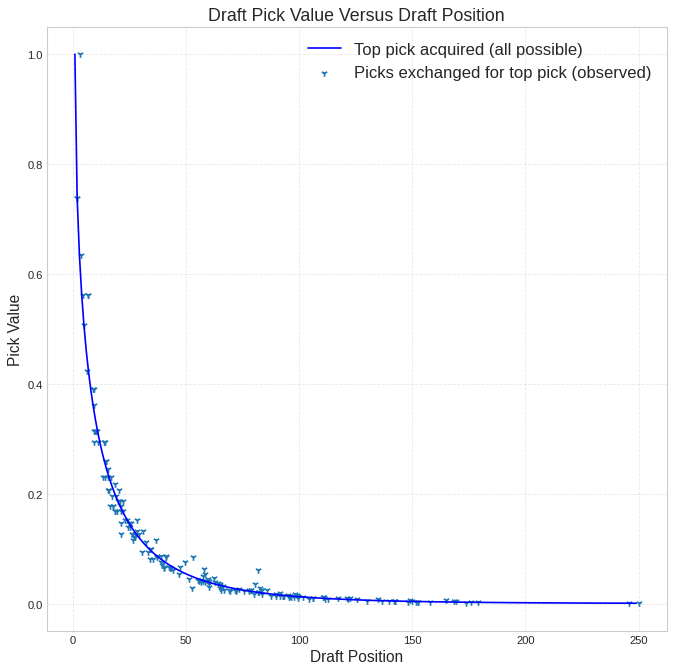

0.9344555895285479


<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
figure(figsize=(10, 10), dpi=80)
x=np.array(range(250))
y=[]
calculatingRScore=[]
warnings.filterwarnings("ignore")
for i in x:
    y.append(math.exp(-lamb*((i-1)**beta))) #Proposed Weibull Distribution versus draft position
plt.style.use('seaborn-whitegrid')
plt.plot(x,y,'b')
plt.scatter(graphX, graphY, marker="1") #Value of Picks Exchanged for Top Pick versus Draft Position
plt.grid(alpha=.4,linestyle='--')
plt.title('Draft Pick Value Versus Draft Position', fontsize=16)
plt.xlabel('Draft Position', fontsize=14)
plt.ylabel('Pick Value', fontsize=14)
plt.legend(['Top pick acquired (all possible)','Picks exchanged for top pick (observed)'], prop={"size":15})
plt.savefig('Draft_Market_Value.png')
plt.show()
plt.savefig('Draft_Values.png')

normalizedList=[] #Develops a normalized list of values between 0 and 1000 rather than 0 and 1
for i in range(len(y)):
  if i>0:
    normalizedList.append(round(y[i]*1000,2))

#Calculating R^2 score of the proposed model
for i in graphX:
  calculatingRScore.append(math.exp(-lamb*((i-1)**beta)))
r2score= r2_score(calculatingRScore,graphY)
print(r2score)

Prints NHL Trade Value Chart

In [30]:
print(normalizedList[0:210])

[1000.0, 737.86, 634.61, 562.4, 506.49, 460.97, 422.76, 390.0, 361.47, 336.33, 313.98, 293.93, 275.85, 259.45, 244.5, 230.81, 218.23, 206.64, 195.93, 186.0, 176.77, 168.18, 160.16, 152.67, 145.65, 139.07, 132.89, 127.07, 121.6, 116.43, 111.56, 106.95, 102.59, 98.46, 94.55, 90.84, 87.31, 83.96, 80.77, 77.74, 74.85, 72.1, 69.48, 66.97, 64.58, 62.3, 60.12, 58.03, 56.03, 54.12, 52.29, 50.53, 48.85, 47.23, 45.68, 44.2, 42.77, 41.4, 40.08, 38.82, 37.6, 36.43, 35.3, 34.21, 33.17, 32.16, 31.19, 30.26, 29.36, 28.49, 27.65, 26.84, 26.06, 25.31, 24.58, 23.87, 23.2, 22.54, 21.91, 21.29, 20.7, 20.13, 19.57, 19.03, 18.52, 18.01, 17.53, 17.06, 16.6, 16.16, 15.73, 15.31, 14.91, 14.52, 14.14, 13.78, 13.42, 13.08, 12.74, 12.42, 12.1, 11.8, 11.5, 11.21, 10.93, 10.66, 10.4, 10.14, 9.89, 9.65, 9.41, 9.18, 8.96, 8.74, 8.53, 8.33, 8.13, 7.94, 7.75, 7.57, 7.39, 7.22, 7.05, 6.88, 6.72, 6.57, 6.42, 6.27, 6.13, 5.99, 5.85, 5.72, 5.59, 5.46, 5.34, 5.22, 5.1, 4.99, 4.88, 4.77, 4.67, 4.56, 4.46, 4.37, 4.27, 4.18, 4

The remainder of this notebook applies the above parameters to determine the discount rate applied to future draft picks.

In [25]:
futureTradesPart1=[]
futureTradesPart2=[]
years=[]
for i in listOfDifferentYearTrades:
  years.append(i[0].split(', '))
  futureTradesPart1.append(i[1].split(', ')) #Splitting the trades involving current and future picks
  futureTradesPart2.append(i[2].split(', '))
trading1=[] #List of Dictionaries of trades
trading2=[]
dictTrading1={} #Dictionaries with the year of the draft pick and its associated value, used to find discounting of future picks
dictTrading2={}
for i in range(len(years)):
  dictTrading1={}
  dictTrading2={}
  for j in range(len(years[i])):
    if j<len(futureTradesPart1[i]): 
      if years[i][j] in dictTrading1:
        dictTrading1[years[i][j]].append(futureTradesPart1[i][j])
      else:
        dictTrading1[years[i][j]]=[futureTradesPart1[i][j]]
    else:
      if years[i][j] in dictTrading2:
        dictTrading2[years[i][j]].append(futureTradesPart2[i][j-len(futureTradesPart1[i])])
      else:
        dictTrading2[years[i][j]]=[futureTradesPart2[i][j-len(futureTradesPart1[i])]]
  trading1.append(dictTrading1)
  trading2.append(dictTrading2)

Discount Rate for 1-for-1 trades

In [26]:
differenceinPickNumber=[]
differenceInValue=[]

def percentageDifference(pick1,pick2,lamb,beta):
  return (math.exp((-lamb*((pick1)-1)**beta))-math.exp(-lamb*((pick2)-1)**beta))/math.exp(-lamb*((pick2)-1)**beta) #Calculation for percentage difference in one-for-one trades


for i in range(len(trading1)): #for loop designed to determine discounting for one-for-one trades
  if len(list(trading1[i].values()))==1 and len(list(trading2[i].values()))==1 and len(list(trading1[i].values())[0])==1 and len(list(trading2[i].values())[0])==1: #Checks that all requirements of the lists are satisfied in order to be a one-for-one trades
    firstYear=list(trading1[i].keys())[0]
    secondYear=list(trading2[i].keys())[0]
    if firstYear<secondYear:#Determines which picks are future picks to determine discounting
      differenceinPickNumber.append(int(trading1[i][firstYear][0])-int(trading2[i][secondYear][0]))
      differenceInValue.append(percentageDifference(int(trading2[i][secondYear][0]),int(trading1[i][firstYear][0]),lamb,beta))
    else: 
      differenceinPickNumber.append(int(trading2[i][secondYear][0])-int(trading1[i][firstYear][0]))
      differenceInValue.append(percentageDifference(int(trading1[i][firstYear][0]),int(trading2[i][secondYear][0]),lamb,beta))

print(len(differenceinPickNumber))
print(statistics.mean(differenceinPickNumber))
print(statistics.mean(differenceInValue))


98
11.112244897959183
0.37694248569189653


In [27]:
print(statistics.mean(differenceinPickNumber))
print(statistics.median(differenceinPickNumber))
print(statistics.stdev(differenceinPickNumber))
print(max(differenceinPickNumber))
print(min(differenceinPickNumber))

11.112244897959183
11.0
17.633077313022692
58
-29


Finding the difference between each side of the trade in the absence of future draft picks, and determining the discount rate applied to make the trade equal in value.

In [28]:
futureValueDiscounting=[] #List with the discounting for every trade involving a future draft picks
for i in range(len(trading1)):
  for j in range(len(trading1[i])):
    keysInvolved1=list(trading1[i].keys()) #Years of the picks on one side of the trade
    valuesInvolved1=list(trading1[i].values()) #Picks involved on one side of the trade
    keysInvolved2=list(trading2[i].keys())
    valuesInvolved2=list(trading2[i].values())
    totalOnTrade1Side=0 #Sum of all trade values for one side
    totalOnTrade2Side=0 #Sum of all trade values for the other side
    listOfYears=[]
    listOfOneYearValues1=[] #List of picks one year in the future on one side of the trade
    listOfTwoYearValues1=[] #List of picks two years into the future on one side of the trade
    listOfOneYearValues2=[]
    listOfTwoYearValues2=[]
    for i in keysInvolved1: #Creating the full list of years from the keys of the dictionary
      listOfYears.append(int(i))
    for i in keysInvolved2:
      listOfYears.append(int(i))
    for i in range(len(listOfYears)):
      if i<len(keysInvolved1):
        if listOfYears[i]==min(listOfYears):
          for j in valuesInvolved1[i]:
            totalOnTrade1Side+=math.exp(-lamb*((int(j)-1)**beta)) #Take each current draft pick from one side of the trade and use the proposed model to determine their value
        else:
          for j in range(len(valuesInvolved1[i])):
            if int(keysInvolved1[i])==min(listOfYears)+1:
              listOfOneYearValues1.append(int(valuesInvolved1[i][j]))
            else:
              listOfTwoYearValues1.append(int(valuesInvolved1[i][j]))
      else:
        if listOfYears[i]==min(listOfYears):
          for j in valuesInvolved2[i-len(keysInvolved1)]:
            totalOnTrade2Side+=math.exp(-lamb*((int(j)-1)**beta)) #Take each draft pick on the other side of the trade from the current year
        else:
          for j in range(len(valuesInvolved2[i-len(keysInvolved1)])):
            if int(keysInvolved2[i-len(keysInvolved1)])==min(listOfYears)+1:
              listOfOneYearValues2.append(int(valuesInvolved2[i-len(keysInvolved1)][j]))
            else:
              listOfTwoYearValues2.append(int(valuesInvolved2[i-len(keysInvolved1)][j]))
  if len(listOfTwoYearValues1)==0 and len(listOfTwoYearValues2)==0:
    presentValueDifferenceinTradeValue=totalOnTrade1Side-totalOnTrade2Side
    futureValueDifferenceInTradeValue=0
    for j in listOfOneYearValues2:
      futureValueDifferenceInTradeValue+=math.exp(-lamb*((j-1)**beta)) #Determining the value of draft picks taken in the future assuming they were taken in the present year
    for j in listOfOneYearValues1:
      futureValueDifferenceInTradeValue-=math.exp(-lamb*((j-1)**beta))
    percentDifference=(abs(futureValueDifferenceInTradeValue)-abs(presentValueDifferenceinTradeValue))/abs(presentValueDifferenceinTradeValue)*100 #Determine the percentage difference in draft value between present draft picks and future draft picks
    futureValueDiscounting.append(percentDifference) #Adds the future discounting to the discounting list to determine how much teams discount future draft picks

print(statistics.mean(futureValueDiscounting))
print(statistics.median(futureValueDiscounting))
print(min(futureValueDiscounting))

42.433552965401816
39.49564559508103
-56.86361920072931


Classifying the different types of trades.

In [29]:
dictDifferentTypesOfFutureTrades={} #Dictionary with each type of trade
for i in range(len(trading1)):
  if len(trading1[i].values())>len(trading2[i].values()):
    typeOfTrade=(len(trading1[i].values()),len(trading2[i].values()))
  else:
    typeOfTrade=(len(trading2[i].values()),len(trading1[i].values()))
  if typeOfTrade in dictDifferentTypesOfFutureTrades:
    dictDifferentTypesOfFutureTrades[typeOfTrade]+=1
  else:
    dictDifferentTypesOfFutureTrades[typeOfTrade]=1

stdevList=[] #List to determine standard deviation of number of picks in trades with future picks
counter=0
while counter<len(trading1):
  if counter<111:
    stdevList.append(1)
  elif counter<163:
    stdevList.append(2)
  else:
    stdevList.append(3)
  counter+=1


print(statistics.stdev(stdevList))
print(dictDifferentTypesOfFutureTrades)

0.4999630437192296
{(1, 1): 111, (2, 1): 51, (3, 1): 2, (2, 2): 1}
